<b><center>
<span style="font-size: 24pt; line-height: 1.2">
< Code Sample for Lovelytics Internship Application ><br>
</span>
</center></b>
</span><br>
<p>
<i><center>
<span style="font-size: 20pt; line-height: 1.2">
Jino Kwon<br>
</span>
</center></i>

### Introduction : The present code sample is from my independent project on the influence of moral emotional expression on information diffusion of moralized/political content; the idea is that the more people use moral emotional words such as 'right' or 'justice' in their tweet, the more likely their message will be shared by other users. I'm using a preexisting dataset from a published paper on a related topic that scraped Twitter messages from political elites in the year leading up to the 2016 Presidential Election. I'm utilizing various Twitter meta-data (e.g., the number of followers) and sentiment scores for two moral emotions---outrage and fear---which I generate using NLP techniques to build predictive models for the number of retweets for each message. 

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from numpy import inf

import nltk
from nltk.tokenize import word_tokenize
from nltk.collocations import *
from nltk import FreqDist
lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer

# 1. Data Cleaning and Preparation

In [ ]:
# Congress raw Tweeter data
df = pd.read_csv(r'C:\Users\jino\Desktop\iedological assym\congress\data\congress_raw.csv')
# Drop two columns that contain unncessary information
df = df.drop(["dw_extr", "dwextr_rs"], axis=1)
# Recode categorical values so that '1' means 'yes' and '0' means 'no'
df.media = df.media + 0.5
df.gender = df.gender + 0.5
df.race = df.race + 0.5

# Create a new column for log tranformed values for 'followers'
df['ln_followers'] = np.log(df['followers'])
# Create a new column for log transformed values for 'retweet'
df['ln_retweet'] = np.log(df['retweet_count'])
# Replaced all '-inf' to 0
df = df.replace({'ln_retweet': {-inf: 0}})

# Create a new column that labels 'conservative' (as 1) or 'liberal' (as 0)
def conserv(x):
    if x >= 0 : return 1
    elif x < 0 : return 0
    else : return 0
df["conserv"] = df["dw_score"].apply(conserv)

# Checking the new column, 'conserv'
df['conserv'].value_counts()
# we have 152103 conservatives and 124647 liberals!

# For my analysis, I'd randomly select 5000 from liberals and conservatives.
df_lib = df[(df['conserv'] == 0)].sample(10000)
df_conserv = df[(df['conserv'] == 1)].sample(10000)
df1 = pd.concat([df_lib, df_conserv])

# Clean tweets and put them in a new column, 'clean_text'
stop_words = set(stopwords.words('english')) 
stop_words.update(['http' , 'xx' , 'x' ,'xe' , 'co'])
#stop_words.update(['potus', 'jacksonleetx', 'prd', 'akas', 'sorors', 'actionforpr', 'ronwyden', 'orbizsummit'])

# Create a function that cleans text
def clean_lemma(txt): 
  tmp = re.sub(r'^https?:\/\/.*[\r\n]*', '', txt, flags=re.MULTILINE)
  tmp = re.sub('[^a-zA-Z]+', ' ', txt)
  tmp = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(tmp)]
  tmp = [word for word in tmp if word not in stop_words]
  tmp = [w for w in tmp if len(w)>2]
  tmp = ' '.join(tmp)
  return tmp

df1['clean_text'] = df1['text'].str.lower()
df1['clean_text'] = df1.clean_text.apply(clean_lemma)

* Creating sentiment scores using the NRC dictionary: a previously-validated dictionary for emotional words

In [ ]:
# Prepping the NRC dictionary for sentiment analysis
filepath = r"C:\Users\jino\Desktop\Final Project\NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
nrc_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
# I'm deleting a list of entries that are not associated with any emotion
nrc_df = nrc_df[nrc_df.association != 0]
# Create a 'outrage' dictionary
nrc_outrage = nrc_df[(nrc_df.emotion == 'anger') | (nrc_df.emotion == 'disgust')]
# Create a 'fear' dictionary
nrc_fear = nrc_df[nrc_df.emotion == 'fear']
# Create a 'positive' dictionary
nrc_pos = nrc_df[nrc_df.emotion == 'positive']
# Create a 'negative' dictionary
nrc_neg = nrc_df[nrc_df.emotion == 'negative']

* Create functions for outrage/fear

In [ ]:
# Create a function for 'outrage' score
def outrage_senti(txt):
    token = nltk.word_tokenize(txt)
    ow = []
    for word in token:
        for o in nrc_outrage['word']:
            if word == o:
                ow.append(word)
    oc = len(ow)
    try:
      S = oc / len(token)
    except:
      S = 0
    return S

# Create a function for 'fear' score
def fear_senti(txt):
    token = nltk.word_tokenize(txt)
    fw = []
    for word in token:
        for f in nrc_fear['word']:
            if word == f:
                fw.append(word)
    fc = len(fw)
    try:
      S = fc / len(token)
    except:
      S = 0
    return S

# Create a fuction for 'posneg' score
def posneg(txt):
    token = nltk.word_tokenize(txt)
    pw = []
    nw = []
    for word in token:
        for p in nrc_pos['word']:
            if word == p:
                pw.append(word)
        for n in nrc_neg['word']:
            if word == n:
                nw.append(word)
    pc = len(pw)
    nc = len(nw)
    try:
      S = ( pc*(1) + nc*(-1) ) / (pc+nc)
    except:
      S = 0
    return S

# Create a new column for 'outrage score'
df1['outrage'] = df1.clean_text.apply(outrage_senti)
# Create a new column for 'fear score'
df1['fear'] = df1.clean_text.apply(fear_senti)
# Create a new column for 'pos/neg' score
df1['posneg'] = df1.clean_text.apply(posneg)

In [ ]:
# Save the df1 file
df1.to_csv(r'C:\Users\jino\Desktop\Final Project\preprocessed_data')

# 2. Building ML Models!

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Supress Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

The following is what the raw dataset that I downloaded looks like: 

In [20]:
df = pd.read_csv(r'C:\Users\jino\Desktop\Jino Kwon Final Project (NLP)\congress_raw (original data).csv')
df.head()

,text,elite,retweet_count,media,gender,dw_extr,dwextr_rs,dw_score,race,age,followers
0,@jnblsm Thanks for reaching out. Wes Scherman...,_Hunter,8,-0.5,0.5,0.511,0.413264,0.511,0.5,69,13068.0
1,.@sdut Let\xe2\x80\x99s make America great aga...,_Hunter,155,0.5,0.5,0.511,0.413264,0.511,0.5,69,13068.0
2,'This afternoon I'm meeting w/ White House to ...,Abraham,2,-0.5,0.5,0.499,0.403560,0.499,0.5,63,6482.0
3,My statement on the FEMA 90-10 cost-share anno...,Abraham,3,0.5,0.5,0.499,0.403560,0.499,0.5,63,6482.0
4,Louisiana congressional delegation wrote to FE...,Abraham,1,-0.5,0.5,0.499,0.403560,0.499,0.5,63,6482.0


The following is what the cleaned data (following the steps outlined in the data cleaning section above) looks like:

In [2]:
df = pd.read_csv('C:/Users/jino/Desktop/Jino Kwon Final Project (NLP)/preprocessed_data.csv')
df.head()

,Unnamed: 0,text,elite,retweet_count,media,gender,dw_score,race,age,followers,ln_followers,ln_retweet,conserv,clean_text,outrage,fear,posneg
0,100977,@POTUS supports #Congress #ActionForPR to addr...,JoseSerrano,5,0.0,1.0,-0.489,0.0,74,22282.00,10.011534,1.609438,0,potus support congress actionforpr address prd...,0.090909,0.000000,1.0
1,276271,Posing with my sorors this week for AKAs on th...,Wilson,2,1.0,0.0,-0.476,0.0,75,18202.00,9.809287,0.693147,0,posing sorors week akas hill day jacksonleetx ...,0.000000,0.000000,0.0
2,212898,The current federal minimum wage of $7.25 an h...,SenSanders,1715,0.0,1.0,-0.513,1.0,76,2587562.39,14.766227,7.447168,0,current federal minimum wage hour starvation w...,0.000000,0.090909,-1.0
3,143503,'October's jobs numbers show economy making st...,NancyPelosi,37,0.0,0.0,-0.492,1.0,77,1297533.00,14.075975,3.610918,0,october job number show economy making strong ...,0.062500,0.000000,1.0
4,201753,Great to be at the #ORBizSummit w/@RonWyden to...,SenJeffMerkley,4,1.0,1.0,-0.451,1.0,61,47314.00,10.764562,1.386294,0,great orbizsummit ronwyden today hear business...,0.000000,0.000000,1.0


### Model 1: just text data (Vectorizer + ML models)
The first exploratory model only uses the original Twitter messages and the number of retweet counts

In [79]:
# Preparing the data
X = df['text']
y = df['retweet_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

* CountVectorizer with retweet_count

In [76]:
count = CountVectorizer(ngram_range=(1,2), min_df = 3)
X_train = count.fit_transform(X_train)
y_train = y_train
X_test = count.transform(X_test)
y_test = y_test

In [78]:
param_grid = {"max_depth": [10, 50], "n_estimators": [1, 4, 16, 32]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5).fit(X_train, y_train)
print("Best Parameters with GridSearchCV: {}".format(rfr_grid.best_params_))
print("Best Cross Validation Score with GridSearchCV: {:.4f}".format(rfr_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(rfr_grid.score(X_test, y_test)))

Best Parameters with GridSearchCV: {'max_depth': 10, 'n_estimators': 32}
Best Cross Validation Score with GridSearchCV: -0.1476
Test Score: 0.0006


* TfidfVectorizer with retweet_count

In [80]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3)
X_train = tfidf.fit_transform(X_train)
y_train = y_train
X_test = tfidf.transform(X_test)
y_test = y_test

In [81]:
param_grid = {"max_depth": [10, 50], "n_estimators": [1, 4, 16, 32]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5).fit(X_train, y_train)
print("Best Parameters with GridSearchCV: {}".format(rfr_grid.best_params_))
print("Best Cross Validation Score with GridSearchCV: {:.4f}".format(rfr_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(rfr_grid.score(X_test, y_test)))

Best Parameters with GridSearchCV: {'max_depth': 10, 'n_estimators': 32}
Best Cross Validation Score with GridSearchCV: -0.1622
Test Score: -0.1798


* Running the same 2 models but with log transformed values for retweet_count
    * The rationale for using ln (log-transformed) values for the number of retweets is covered in a later section.

In [10]:
# Preparing the data
X = df['text']
y = df['ln_retweet']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

* CounVectorizer with ln_retweet

In [8]:
count = CountVectorizer(ngram_range=(1,2), min_df = 3)
X_train = count.fit_transform(X_train)
y_train = y_train
X_test = count.transform(X_test)
y_test = y_test

In [9]:
param_grid = {"max_depth": [10, 50], "n_estimators": [1, 4, 16, 32]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5).fit(X_train, y_train)
print("Best Parameters with GridSearchCV: {}".format(rfr_grid.best_params_))
print("Best Cross Validation Score with GridSearchCV: {:.4f}".format(rfr_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(rfr_grid.score(X_test, y_test)))

Best Parameters with GridSearchCV: {'max_depth': 50, 'n_estimators': 32}
Best Cross Validation Score with GridSearchCV: 0.1068
Test Score: 0.1242


*  TfidfVectorizer with ln_retweet

In [11]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3)
X_train = tfidf.fit_transform(X_train)
y_train = y_train
X_test = tfidf.transform(X_test)
y_test = y_test

In [12]:
param_grid = {"max_depth": [10, 50], "n_estimators": [1, 4, 16, 32]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5).fit(X_train, y_train)
print("Best Parameters with GridSearchCV: {}".format(rfr_grid.best_params_))
print("Best Cross Validation Score with GridSearchCV: {:.4f}".format(rfr_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(rfr_grid.score(X_test, y_test)))

Best Parameters with GridSearchCV: {'max_depth': 50, 'n_estimators': 32}
Best Cross Validation Score with GridSearchCV: 0.1030
Test Score: 0.1297


### Model 2:  ML models with 3 key variables: political identity strength & outrage & fear

In [23]:
lm = smf.ols(formula = 'ln_retweet ~ fear * outrage + dw_score', data = df).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_retweet   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     134.9
Date:                Thu, 19 Dec 2019   Prob (F-statistic):          6.69e-114
Time:                        22:22:23   Log-Likelihood:                -37037.
No. Observations:               20000   AIC:                         7.408e+04
Df Residuals:                   19995   BIC:                         7.412e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.3426      0.013     99.583   

* Model 2-1: KNN Regression

In [24]:
X = df[['outrage', 'fear', 'dw_score']]
y = df['ln_retweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
param_grid = {'n_neighbors': [5, 10, 15]}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5).fit(X_train_scaled, y_train)
print("Best Parameters with GridSearchCV: {}".format(grid.best_params_))
print("Best Cross Validation score with GridSearchCV: {:.4f}".format(grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'n_neighbors': 15}
Best Cross Validation score with GridSearchCV: -0.0387
Test Score: -0.0192


* Model 2-2: Random Forest Model

In [28]:
param_grid = {"max_depth": [10, 50, 100], "n_estimators": [1, 4, 16, 32, 64]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5).fit(X_train_scaled, y_train)
print("Best Parameters with GridSearchCV: {}".format(rfr_grid.best_params_))
print("Best Cross Validation Score with GridSearchCV: {:.4f}".format(rfr_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(rfr_grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'max_depth': 10, 'n_estimators': 64}
Best Cross Validation Score with GridSearchCV: 0.0079
Test Score: 0.0062


### Model 3: 3 ML models with more variables: + media, gender,	race, followers	

In [5]:
lm = smf.ols(formula = 'ln_retweet ~ fear + outrage + posneg + dw_score + media + gender + race + followers', data = df).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_retweet   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     1180.
Date:                Wed, 18 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:21:54   Log-Likelihood:                -33437.
No. Observations:               20000   AIC:                         6.689e+04
Df Residuals:                   19991   BIC:                         6.696e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2458      0.029     42.848      0.0

In [3]:
# Data Preparation
X = df[['outrage', 'fear', 'dw_score', 'media', 'gender', 'followers', 'race', 'posneg']]
y = df['ln_retweet']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

* Model 3-1. Lasso model

In [4]:
lasso_pipe = make_pipeline(Lasso())
lasso_param_grid = {'lasso__alpha': np.linspace(0.1, 100.1, 1)}
lasso_grid = GridSearchCV(lasso_pipe, lasso_param_grid, cv=5).fit(X_train_scaled, y_train)

print("Best Parameters with GridSearchCV: {}".format(lasso_grid.best_params_))
print("Best Cross-Validation Score with GridSearchCV: {:.4f}".format(lasso_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test set Score: {:.4f}".format(lasso_grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'lasso__alpha': 0.1}
Best Cross-Validation Score with GridSearchCV: 0.2957
Test set Score: 0.3160


* Model 3-2. Ridge model

In [5]:
ridge_pipe = make_pipeline(Ridge())
ridge_param_grid = {'ridge__alpha': np.linspace(0.1, 100.1, 1)}
ridge_grid = GridSearchCV(ridge_pipe, ridge_param_grid, cv=5).fit(X_train_scaled, y_train)

print("Best Parameters with GridSearchCV: {}".format(ridge_grid.best_params_))
print("Best Cross-Validation Score with GridSearchCV: {:.4f}".format(ridge_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test set Score: {:.4f}".format(ridge_grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'ridge__alpha': 0.1}
Best Cross-Validation Score with GridSearchCV: 0.3137
Test set Score: 0.3377


* Model 3-3: KNN Regression

In [6]:
param_grid = {'n_neighbors': [5, 10, 20, 50, 100]}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5).fit(X_train_scaled, y_train)
print("Best Parameters with GridSearchCV: {}".format(grid.best_params_))
print("Best Cross Validation score with GridSearchCV: {:.4f}".format(grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'n_neighbors': 20}
Best Cross Validation score with GridSearchCV: 0.4304
Test Score: 0.4656


* Model 3-4: Support Vector Machine

In [7]:
param_grid = {'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(SVR(), param_grid, cv=5).fit(X_train_scaled, y_train)
print("Best Parameters with GridSearchCV: {}".format(grid.best_params_))
print("Best Cross Validation score with GridSearchCV: {:.4f}".format(grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'C': 50, 'gamma': 0.005}
Best Cross Validation score with GridSearchCV: 0.4483
Test Score: 0.5011


* Model 3-5:Random Forest

In [8]:
param_grid = {"max_depth": [10, 50, 100], "n_estimators": [1, 4, 16, 32, 64]}
rfr_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5).fit(X_train_scaled, y_train)
print("Best Parameters with GridSearchCV: {}".format(rfr_grid.best_params_))
print("Best Cross Validation Score with GridSearchCV: {:.4f}".format(rfr_grid.best_score_))

# The following shows the evaluation of this model using the test set
print("Test Score: {:.4f}".format(rfr_grid.score(X_test_scaled, y_test)))

Best Parameters with GridSearchCV: {'max_depth': 10, 'n_estimators': 64}
Best Cross Validation Score with GridSearchCV: 0.5493
Test Score: 0.5829


### Visualizations
* The following two histograms demonstrate why I chose to look at ln_retweet. We can see below that the data distribution is highly skewed in retweet_count in its raw form. So, just as economic researchers often use log transformations for variables such as income, I used log transformed values for the number of retweets to make the data more normally distributed (the histograms below will show this point).

In [22]:
df1 = df[['ln_retweet', 'fear', 'outrage', 'posneg', 'dw_score', 'media', 'gender', 'race', 'followers']].copy()
des = df1.describe()
des = des.transpose()
des

,count,mean,std,min,25%,50%,75%,max
ln_retweet,20000.0,1.473084,1.562466,0.000,0.000,1.098612,2.197225,1.080442e+01
fear,20000.0,0.040910,0.071026,0.000,0.000,0.000000,0.076923,5.714286e-01
outrage,20000.0,0.046866,0.089728,0.000,0.000,0.000000,0.076923,1.000000e+00
posneg,20000.0,0.338382,0.672388,-1.000,0.000,0.333333,1.000000,1.000000e+00
dw_score,20000.0,0.048023,0.451323,-0.744,-0.384,0.022500,0.453000,9.190000e-01
media,20000.0,0.256250,0.436572,0.000,0.000,0.000000,1.000000,1.000000e+00
gender,20000.0,0.751300,0.432270,0.000,1.000,1.000000,1.000000,1.000000e+00
race,20000.0,0.818850,0.385152,0.000,1.000,1.000000,1.000000,1.000000e+00
followers,20000.0,149050.799889,435449.924468,629.000,15589.000,24230.000000,47314.000000,2.587562e+06


In [20]:
df1 = df[['retweet_count']].copy()
des = df1.describe()
des = des.transpose()
des

,count,mean,std,min,25%,50%,75%,max
retweet_count,20000.0,53.10765,514.937927,0.0,1.0,3.0,9.0,49238.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216C0FDB8C8>]],
      dtype=object)

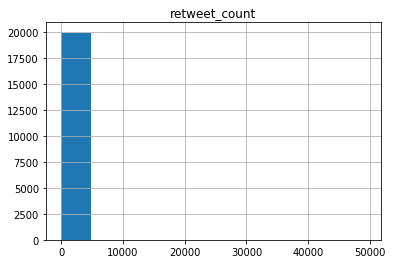

In [13]:
df.hist(column='retweet_count')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216C8013648>]],
      dtype=object)

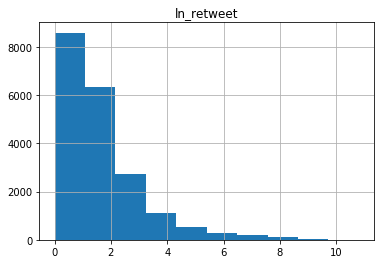

In [14]:
# Now, the data looks more normally distributed.
df.hist(column='ln_retweet')

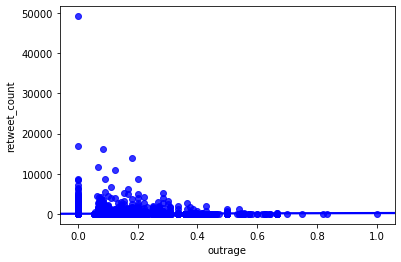

In [88]:
import seaborn as sns
x = sns.regplot(x="outrage", y="retweet_count", data=df, color='b')

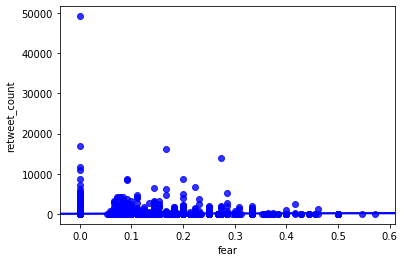

In [89]:
x = sns.regplot(x="fear", y="retweet_count", data=df, color='b')

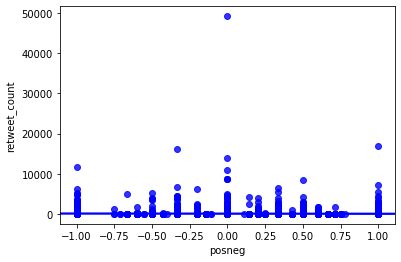

In [9]:
x = sns.regplot(x="posneg", y="retweet_count", data=df, color='b')

* Visualization : the following wordcloud shows a list of words that show up most often in tweets. Since my sentiment analysis counts the number of words that are in my dictionary, it would be interesting to see the wordcloud.

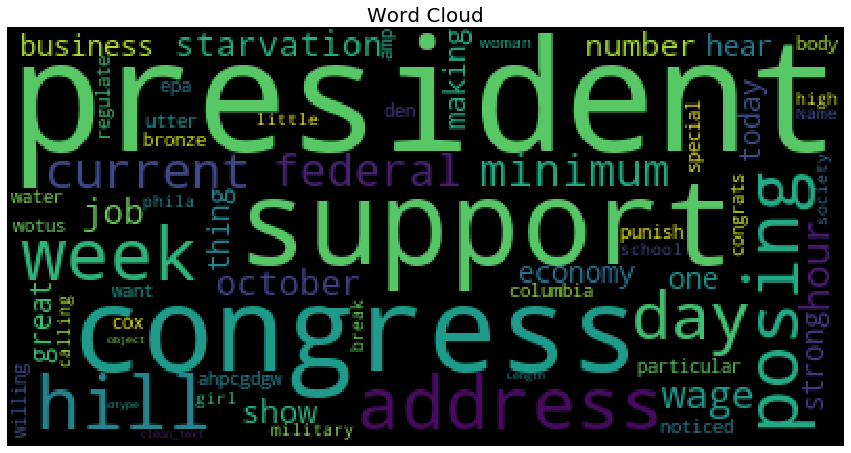

In [19]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
stopwords.update(['potus', 'jacksonleetx', 'prd', 'akas', 'sorors', 'actionforpr', 'ronwyden', 'orbizsummit'])

plt.figure(figsize = (15,15))

# stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'black',
                      max_words = 1000,
                      stopwords = stopwords,
                      max_font_size = 120,
                      random_state = 42).generate(str(df['clean_text']))

plt.imshow(wordcloud)
plt.title('Word Cloud', fontsize = 20)
plt.axis('off')
plt.show()